In [3]:
import numpy as np
import scipy as sp
import numpy.linalg as npl
import matplotlib.pyplot as plt



## PMM

In [4]:
#constants

theta_i = 20 * np.pi / 180 #rad
LAMBDA  = 400*1e-9
D       = 30 * LAMBDA
n_star  = 1.43 #complex optical index

P       = 99 #number of discretization nodes, also number of truncated terms
M       = (P-1)//2
A       = np.zeros((2*P,2*P), dtype = "complex128")
B       = np.zeros(2*P, dtype = "complex128")

grid    = np.linspace(0,D,P)
Gamma   = n_star #s-polarization

In [5]:
def u_inc(x,z): #incident wave
    return np.exp(1j * 2*np.pi / LAMBDA * (x*np.sin(theta_i) - z*np.cos(theta_i)))

s_1 = lambda q : np.sin(theta_i) + q * LAMBDA / D

def c_1(q):
    if (np.abs(s_1(q)) <= 1):
        return np.sqrt(1 - s_1(q)**2)
    else:
        return 1j * np.sqrt(s_1(q)**2 - 1)
    
def v(q,x,z):
    return np.exp(1j * 2*np.pi/LAMBDA * (x * s_1(q) + z * c_1(q)))




s_2 = lambda q : s_1(q)/n_star

def c_2(q):
    if (np.abs(s_2(q)) <= 1):
        return np.sqrt(1 - s_2(q)**2)
    else:
        return 1j * np.sqrt(s_2(q)**2 - 1)
def w(q,x,z):
    return np.exp(1j * 2*np.pi/LAMBDA * n_star * (x * s_2(q) + z * c_2(q)))



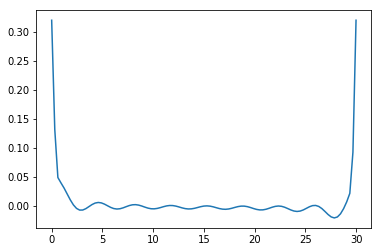

In [6]:
def Surface_Profile(grid,Q,T,sigma,g1 = np.random.normal(1),g2 = np.random.normal(1),):
    F       = np.zeros(2*Q + 1, dtype = "complex128")
    L       = np.arange(-Q,Q+1)
    
    F[Q+1:] = (g1 + 1j*g2) * sigma * np.sqrt(T/D) * np.pi**0.25 \
                           * np.exp(-L[L > 0]**2 * np.pi**2 * T**2 / D**2)
    
    F[:Q] = np.conj(F[Q+1:])
    
    S  = np.empty(len(grid))
    dS = np.empty(len(grid)) 
    for n in range(len(S)):
        S[n]  =     np.vdot( np.real(F), np.cos(2*np.pi * L / D * grid[n])  ) \
                -2 * np.vdot( np.imag(F),np.sin(2*np.pi * L / D * grid[n]))
        
        dS[n] =      np.vdot( -2*np.pi * L / D * np.real(F), np.sin(2*np.pi * L / D * grid[n])  ) \
                -2 * np.vdot(2*np.pi * L / D * np.imag(F), np.cos(2*np.pi * L / D * grid[n]))
    return S,dS


S,dS = Surface_Profile(grid,Q = 20000, T = 0.1*1e-6, sigma =0.005*1e-6)
plt.plot(grid/LAMBDA,S/LAMBDA)
plt.show()

In [109]:
#Assembling matrix A and right hand side B

for n in range(P):
    for m in range(P):
        A[n,m] = v(m - M - 1, grid[n], S[n])

        
for n in range(P):
    for m in range(P,2*P):
        A[n,m] = -w(m - P - M - 1, grid[n], S[n])
    
for n in range(P,2*P):
    for m in range(P):
        A[n,m] = (dS[n - P] * s_1(m - M - 1) - c_1(m - M - 1)) \
                 * v(n - M - 1, grid[n - P], S[n - P])/( np.sqrt(1 + dS[n - P]**2) ) 
                                          
for n in range(P,2*P):
    for m in range(P,2*P):
        A[n,m] = -Gamma * (dS[n - P] * s_2(m - P - M - 1) - c_2(m - P - M -1)) \
                  * w(m - P - M - 1,grid[n - P],S[n - P])/ (np.sqrt(1 + dS[n - P]**2))

for n in range(P):
    B[n] = -u_inc(grid[n], S[n])

for n in range(P,2*P):
    B[n] = -(dS[n - P] * np.sin(theta_i) + np.cos(theta_i)) \
            * u_inc(grid[n - P], dS[n - P])/ np.sqrt(1 + dS[n - P]**2)
                                                                         
X = npl.solve(A,B)          

131.2666691101957


C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arcsin
  if __name__ == '__main__':


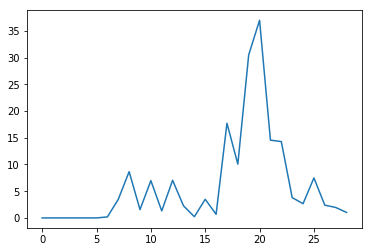

In [110]:
R = X[ : P] #{R_-M,...,R_M}
T = X[P : ] #{T_-M,...,T_M}

rho   = np.empty(2*M + 1)
alpha = np.empty(2*M + 1)
DRC   = np.empty(2*M + 1, dtype = "complex128")
 

theta_s = lambda q : np.arcsin(s_1(q))

for q in range(-M,M+1):
    #print(s_1(q+M))
    rho[q + M]   = np.real(np.abs(R[q + M])**2 * c_1(q) / np.cos(theta_i))
    alpha[q + M] = np.real(Gamma*np.abs(T[q + M])**2 * c_2(q) / np.cos(theta_i))
    DRC[q + M]   = rho[q + M] / (LAMBDA / (D * np.cos(theta_s(q + M))))
    
print(sum(rho + alpha)) #here we must have rho + alpha ~ 1 (conservation of energy) but here we have garbage value 
plt.plot((np.abs(DRC))) #this graph is certainly wrong

## The Fourier series method (FSM)

In [130]:
def Simpson_int(tab):
    n = len(tab) #number of points : even 
    h = D/(n-1)
    s = tab[0]+tab[-1]
    for j in np.arange(1,n//2 ):
        s+=2*tab[2*j]
    for j in np.arange(1,n//2 +1):
        s+=4*tab[2*j-1]
    return s*h/3
        



In [131]:
theta_i = 20 * np.pi / 180 #rad
LAMBDA  = 500 * 1e-9
D       = 30 * LAMBDA
n_star  = 1.43 #complex optical index

P       = 99 #number of discretization nodes, also number of truncated terms
M       = (P - 1) // 2
A       = np.zeros((2*P,2*P), dtype = "complex128")
B       = np.zeros(2*P, dtype = "complex128")

grid    = np.linspace(0,D,P)
Gamma   = n_star #s-polarization

In [121]:
for n in range(P):
    for m in range(P):
        A[n,m] = Simpson_int(v(m - M - 1, grid, S)*np.exp(-1j*2*np.pi/LAMBDA *s_1(n-M-1)*grid))/D

        
for n in range(P):
    for m in range(P,2*P):
        A[n,m] = Simpson_int(-w(m - P-M - 1, grid, S)*np.exp(-1j*2*np.pi/LAMBDA *s_1(n-M-1)*grid))/D
    
for n in range(P,2*P):
    for m in range(P):
        A[n,m] = Simpson_int((dS*s_1(m-M-1)-c_1(m-M-1))/np.sqrt(1+dS**2) *v(m-M-1,grid,S)\
                             *np.exp(-1j*2*np.pi/LAMBDA *s_1(n-P-M-1)*grid)  )/D
                                          
for n in range(P,2*P):
    for m in range(P,2*P):
        A[n,m] = Simpson_int(-Gamma*(dS*s_2(m-P-M-1)+c_2(m-P-M-1) )/np.sqrt(1+dS**2) *w(m-M-1,grid,S)\
                             *np.exp(-1j*2*np.pi/LAMBDA *s_1(n-P-M-1)*grid)    )/D

for n in range(P):
    B[n] = Simpson_int(-u_inc(grid, S)*np.exp(-1j*2*np.pi/LAMBDA *s_1(n-M-1)*grid))/D

for n in range(P,2*P):
    B[n] = Simpson_int( -(dS * np.sin(theta_i) + np.cos(theta_i)) \
           / np.sqrt(1 + dS**2) * u_inc(grid, dS) *np.exp(-1j*2*np.pi/LAMBDA *s_1(n-P-M-1)*grid) )
                                                                         


In [122]:
X = npl.solve(A,B)          

1582.0564712380199


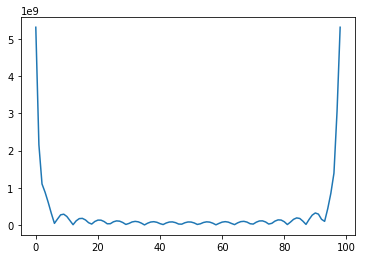

In [123]:
R = X[ : P] #{R_-M,...,R_M}
T = X[P : ] #{T_-M,...,T_M}

rho   = np.empty(2*M + 1)
alpha = np.empty(2*M + 1)
DRC   = np.empty(2*M + 1, dtype = "complex128")
 

theta_s = lambda q : np.arcsin(s_1(q))

for q in range(-M,-M):
    
    rho[q + M]   = np.real(np.abs(R[q + M])**2 * c_1(q) / np.cos(theta_i))
    alpha[q + M] = np.real(Gamma*np.abs(T[q + M])**2 * c_2(q) / np.cos(theta_i))
    DRC[q + M]   = rho[q + M] / (LAMBDA / (D * np.cos(theta_s(q + M)))) 
    
print(sum(rho + alpha)) #here we must have rho + alpha ~ 1 (conservation of energy) but here we have garbage value 
plt.plot((np.abs(DRC))) #this graph is certainly wrong